# Sketching for low-rank nonnegative matrix approximation

## 0.

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def svdr(a, r):
    u, s, vh = sp.linalg.svd(a)
    s = scipy.linalg.diagsvd(s[:r], r, r)
    return u[:, :r], s, vh[:r, :]

In [3]:
def TestMatrix(m, n, distribution='normal', p=None):
    if distribution == 'normal':
        res = np.random.normal(size=(m, n))
    elif p is None: # distribution='rademacher'
        res = np.random.choice([-1,1], size=(m,n))
    else:           # distribution='rademacher'
        res = np.random.choice([0,1,-1], size=(m,n), p=[1-p,p/2,p/2])
    return res

In [4]:
def get_dists(X, res, alg):
    res[alg]['fro'].append(np.linalg.norm(X[X < 0]))
    neg_count = (X < 0).sum()
    res[alg]['density'].append(neg_count/(X.shape[0]*X.shape[1]))
    if len(X[X < 0]) > 0:
        res[alg]['chebyshev'].append(max(abs(X[X < 0])))
    else:
        res[alg]['chebyshev'].append(0)

In [5]:
def get_alg_name(alg, distribution, rho, p1, p2=None):
    d = 'N' if distribution=='normal' else 'Rad'
    if p2 is None:
        alg = f'{alg}({p1}), {d}'
    else:
        alg = f'{alg}({p1},{p2}), {d}'
    if d == 'N':
        alg += '(0,1)'
    elif rho is not None:
        alg += f'({rho})'
    return alg

## 1. Algorithms

### 1.1 SVD

In [6]:
def SVD(X, r, s=100, res=None):
    if res:
        alg = 'SVD'
        res[alg] = {'chebyshev': [], 'fro': [], 'density': []}
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur @ Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Ur, Sr, Vhr = svdr(Yi, r)
        Yi = Ur @ Sr @ Vhr
        if res:
            get_dists(Yi, res, alg)
    for norm in res[alg]:
        res[alg][norm] = np.asarray(res[alg][norm])
    return Yi

### 1.2 Tangent

In [7]:
def Tangent(X, r, s=100, res=None):
    if res:
        alg = 'Tangent'
        res[alg] = {'chebyshev': [], 'fro': [], 'density': []}
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur @ Sr @ Vhr
    Ur, Sr, Vhr = svdr(Yi, r)
    for i in range(s):
        Yi[Yi < 0] = 0
        I = np.eye(Ur.shape[0], Ur.shape[0])
        P = Ur@Ur.T@Yi + (I - Ur@Ur.T)@Yi@Vhr.T@Vhr
        Ur, Sr, Vhr = svdr(P, r)
        Yi = Ur @ Sr @ Vhr
        if res:
            get_dists(Yi, res, alg)
    for norm in res[alg]:
        res[alg][norm] = np.asarray(res[alg][norm])
    return Yi

### 1.3 HMT

In [8]:
def HMT(X, r, p, k, distribution='normal', rho=None, s=100, res=None):
    if res:
        alg = get_alg_name('HMT', distribution, rho, p, k)
        res[alg] = {'chebyshev': [], 'fro': [], 'density': []}
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur @ Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Psi = TestMatrix(n, k, distribution, rho)
        Z1 = Yi @ Psi
        Q, R = np.linalg.qr(Z1)
        for j in range(p):
            Z2 = Q.T @ Yi
            Q, R = np.linalg.qr(Z2.T)
            Z1 = Yi @ Q
            Q, R = np.linalg.qr(Z1)
        Z2 = Q.T @ Yi
        Ur, Sr, Vhr = svdr(Z2, r)
        Yi = Q @ Ur @ Sr @ Vhr
        if res:
            get_dists(Yi, res, alg)
    for norm in res[alg]:
        res[alg][norm] = np.asarray(res[alg][norm])
    return Yi

### 1.4 Tropp

In [9]:
def Tropp(X, r, k, l, distribution='normal', rho=None, s=100, res=None):
    if res:
        alg = get_alg_name('Tropp', distribution, rho, k, l)
        res[alg] = {'chebyshev': [], 'fro': [], 'density': []}
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur @ Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Psi = TestMatrix(n, k, distribution, rho)
        Phi = TestMatrix(l, m, distribution, rho)
        Z = Yi @ Psi
        Q, R = np.linalg.qr(Z)
        W = Phi @ Q
        P, T = np.linalg.qr(W)
        G = np.linalg.inv(T) @ P.T @ Phi @ Yi
        Ur, Sr, Vhr = svdr(G, r)
        Yi = Q @ Ur @ Sr @ Vhr
        if res:
            get_dists(Yi, res, alg)
    for norm in res[alg]:
        res[alg][norm] = np.asarray(res[alg][norm])
    return Yi

### 1.5 GN

In [10]:
def GN(X, r, l, distribution='normal', rho=None, s=100, res=None):
    if res:
        alg = get_alg_name('GN', distribution, rho, l)
        res[alg] = {'chebyshev': [], 'fro': [], 'density': []}
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur @ Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Psi = TestMatrix(n, r, distribution, rho)
        Phi = TestMatrix(l, m, distribution, rho)
        Z = Yi @ Psi
        W = Phi @ Z
        Q, R = np.linalg.qr(W)
        V = (Phi@Yi).T @ Q
        U = Z @ np.linalg.inv(R)
        Yi = U @ V.T
        if res:
            get_dists(Yi, res, alg)
    for norm in res[alg]:
        res[alg][norm] = np.asarray(res[alg][norm])
    return Yi

## 2. Numerical experiments

### 2.1 Random uniform matrices

In [11]:
m = 256
n = 256
r = 64

In [12]:
trials = 10
mean_res = {}

for i in range(trials):
    a = np.random.rand(m, n)
    res = {'SVD':None}
    SVD(a, r, res=res)
    Tangent(a, r, res=res)
    HMT(a, r, p=1, k=70, distribution='normal', res=res)
    HMT(a, r, p=0, k=70, distribution='rademacher', rho=0.2, res=res)
    Tropp(a, r, k=70, l=100, distribution='rademacher', rho=0.2, res=res)
    Tropp(a, r, k=70, l=85, distribution='rademacher', rho=0.2, res=res)
    GN(a, r, l=150, distribution='rademacher', rho=0.2, res=res)
    GN(a, r, l=120, distribution='rademacher', rho=0.2, res=res)
    if not i:
        mean_res = res
    else:
        for alg in res:
            for norm in res[alg]:
                mean_res[alg][norm] += res[alg][norm]

for alg in mean_res:
    for norm in mean_res[alg]:
        mean_res[alg][norm] /= trials               
    

In [13]:
labels = ['Chebyshev', 'Frobenius', 'Density']
colors = ['C0', 'C1', 'C2']
yticks = [10**(-x) for x in range(-1, 16, 2)]
title  = 'Distance to nonnegative matrices' 
titles = np.asarray([['SVD', 'Tangent'],\
                     ['HMT(1,70), N(0,1)', 'HMT(0,70), Rad(0.2)'],\
                     ['Tropp(70,100), Rad(0.2)', 'Tropp(70,85), Rad(0.2)'],\
                     ['GN(150), Rad(0.2)', 'GN(120), Rad(0.2)']])

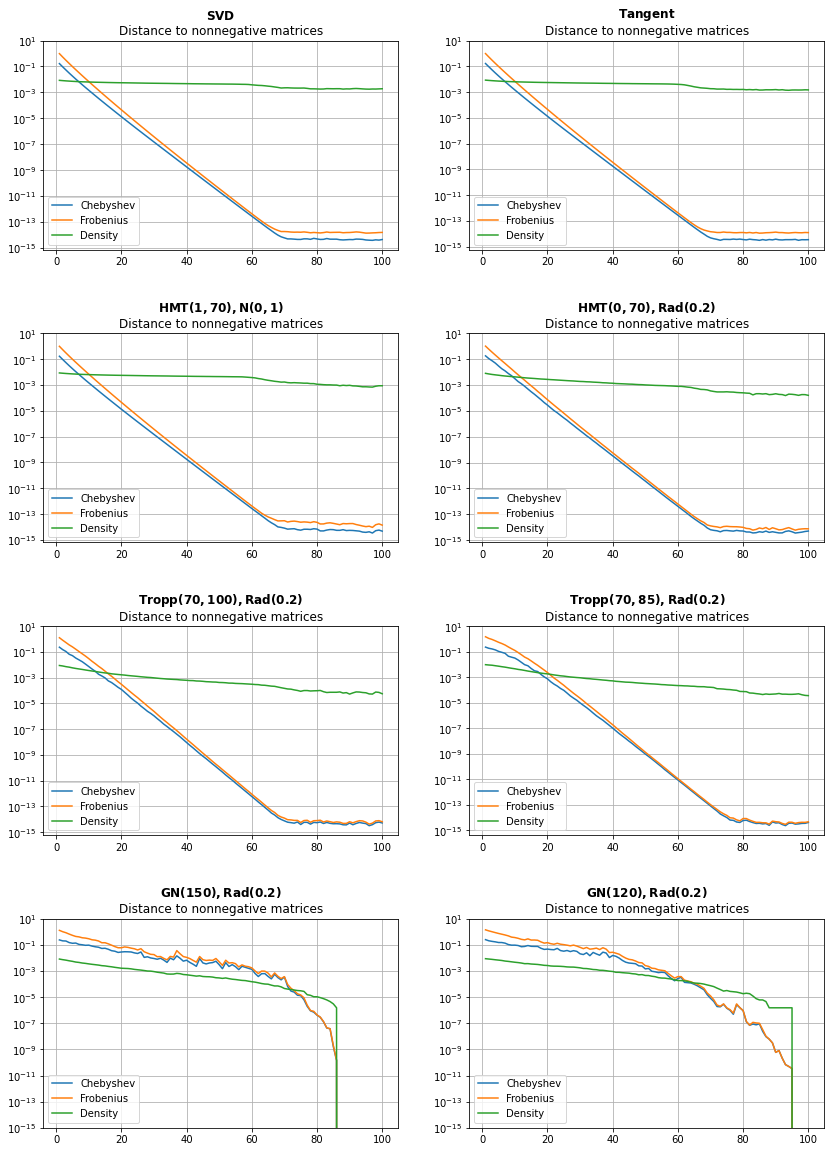

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(14, 20))

for i in range(4):
    for j in range(2):
        key = titles[i,j]
        ax[i,j].plot(range(1, 101), mean_res[key]['chebyshev'], colors[0], label=labels[0])
        ax[i,j].plot(range(1, 101), mean_res[key]['fro'],       colors[1], label=labels[1])
        ax[i,j].plot(range(1, 101), mean_res[key]['density'],   colors[2], label=labels[2])
        ax[i, j].set_title('$\\bf{%s}$\n%s' % (titles[i,j], title))
        ax[i, j].grid()
        ax[i, j].set_yscale('log')
        ax[i, j].set_yticks(yticks)
        ax[i, j].legend(loc='lower left')

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.show()

### 2.2 Images

In [15]:
img = mpimg.imread('img.jpg', format='jpg')
img = img.mean(axis=2)

ur, sr, vhr = svdr(img, 50)
img_r = ur @ sr @ vhr

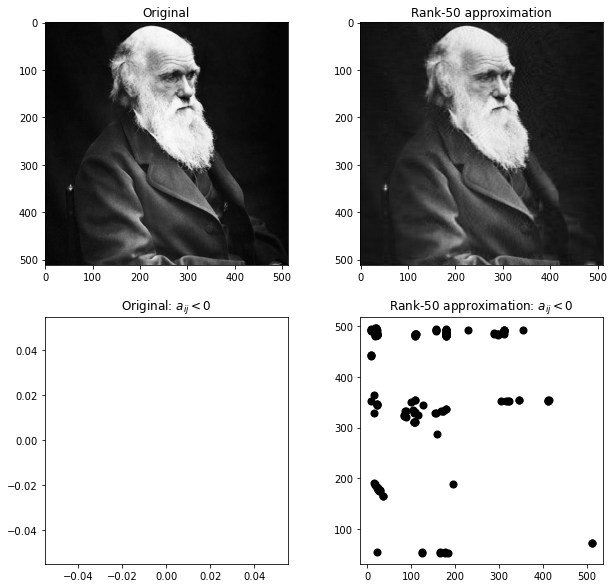

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0,0].set_title('Original')
ax[0,0].imshow(img, cmap='gray')

ax[0,1].set_title('Rank-50 approximation')
ax[0,1].imshow(img_r, cmap='gray')

ax[1,0].set_title(r'Original: $a_{ij} < 0$')
ax[1,0].scatter(*np.where(img < 0), s=50, c='k')

ax[1,1].set_title(r'Rank-50 approximation: $a_{ij} < 0$')
ax[1,1].scatter(*np.where(img_r < 0), s=50, c='k')

plt.subplots_adjust(wspace=0.3)

In [17]:
r = 50
res = {'SVD':None}

img_svd     = SVD(img, r, s=300, res=res)
img_tangent = Tangent(img, r, s=300, res=res)
img_hmt     = HMT(img, r, p=0, k=60, distribution='rademacher', rho=0.2, s=300, res=res)
img_tropp   = Tropp(img, r, k=60, l=120, distribution='rademacher', rho=0.2, s=300, res=res)
img_gn      = GN(img, r, l=340, distribution='rademacher', rho=0.2, s=300, res=res)

In [18]:
labels = ['Chebyshev', 'Frobenius', 'Density']
colors = ['C0', 'C1', 'C2']
yticks = [10**(-x) for x in range(-1, 16, 2)]
title  = 'Distance to nonnegative matrices'
titles = ['SVD', 'Tangent', 'HMT(0,60), Rad(0.2)', 'Tropp(60,120), Rad(0.2)', 'GN(340), Rad(0.2)']
imgs   = [img_svd, img_tangent, img_hmt, img_tropp, img_gn]

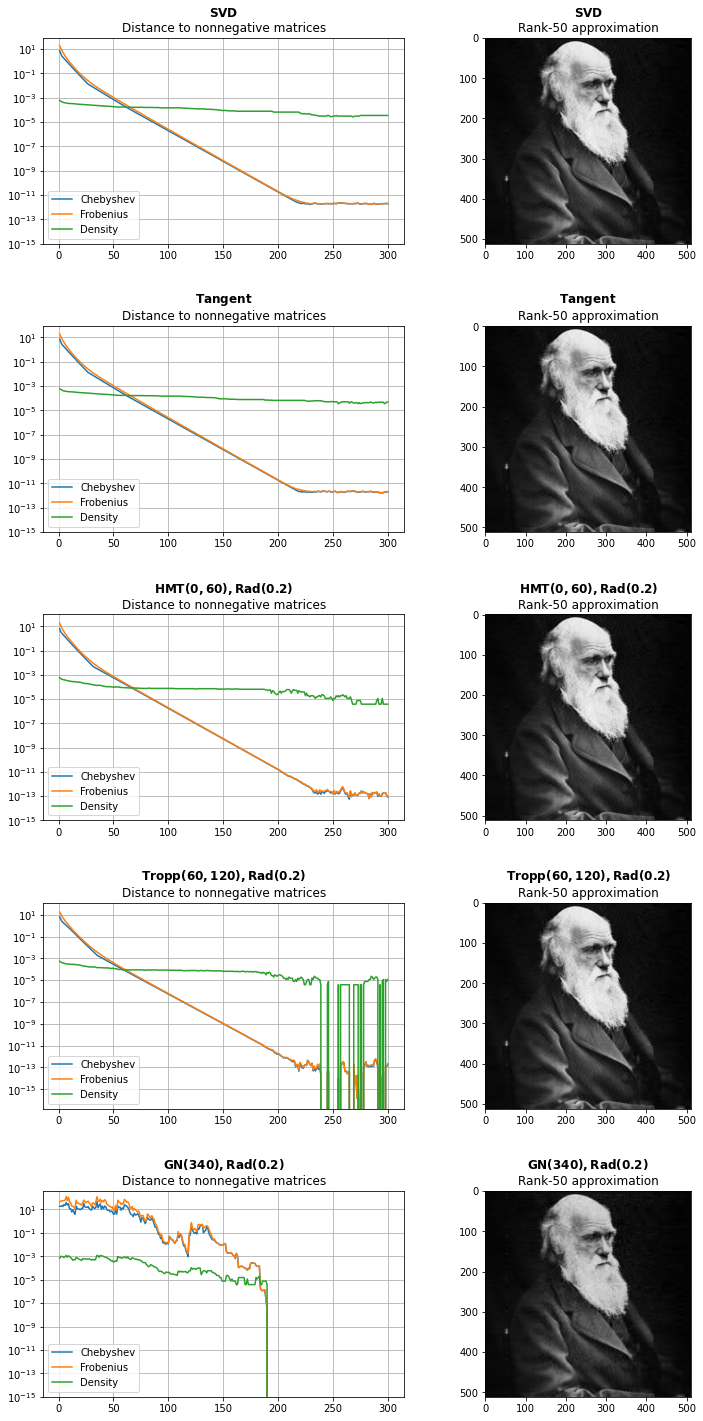

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(13, 25))

for i in range(5):
    key = titles[i]
    ax[i,0].plot(range(1, 301), res[key]['chebyshev'], colors[0], label=labels[0])
    ax[i,0].plot(range(1, 301), res[key]['fro'],       colors[1], label=labels[1])
    ax[i,0].plot(range(1, 301), res[key]['density'],   colors[2], label=labels[2])
    ax[i,0].set_yscale('log')
    ax[i,0].set_yticks(yticks)
    ax[i,0].set_title('$\\bf{%s}$\n%s' % (titles[i], title))
    ax[i,0].legend(loc='lower left')
    ax[i,0].grid()
    
    ax[i,1].set_title('$\\bf{%s}$\n%s' % (titles[i], 'Rank-50 approximation'))
    ax[i,1].imshow(imgs[i], cmap='gray')

plt.subplots_adjust(wspace=0.01, hspace=0.4)